In [3]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
import emcee

import utils
import model_spectra as NN
import fitting

import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import corner

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

# Check Autocorrelation Time of MCMC chain for DEIMOS

In [79]:
autocorr = np.load('emcee_autocorr.npy')
chain = emcee.backends.HDFBackend('chain.h5')
index = len(autocorr)

n = np.arange(1, index + 1) * 100
y = autocorr
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1*(y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

# Restore Neural Network

In [2]:
# read in the standard wavelength grid onto which we interpolate spectra.
wavelength = utils.load_wavelength_array()

# read in all individual neural networks we'll need. 
NN_coeffs = utils.read_in_neural_network(name='norm_spectra_approx')

# Restore Processed Spectra

In [3]:
# Restore Observed spectra
D_PayneDir = utils.D_PayneDir
SpectraDir = D_PayneDir + 'spectra/obs_spectra/'
SpectraFile = 'm15_Horne.npz'
temp = np.load(SpectraDir + SpectraFile)
obj = temp['obj']
norm_spectra = temp['norm_spec']
full_spectra = temp['spec']
spectral_err = temp['spec_err']
dv = temp['dv']
RA_Dec = SkyCoord(temp['RA_Dec'])
temp.close()

### Spectra Selection

In [4]:
# Standard Stars
spec_ind = 8

full_spec = full_spectra[spec_ind]
norm_spec = norm_spectra[spec_ind]
spec_err = spectral_err[spec_ind]

### Apply Mask

In [5]:
# kirby_2008_stellar = utils.get_spectral_mask_dict(name='kirby_2008_stellar')
mask = utils.generate_mask_from_file(name='008.0010337')
spec_err[mask] = 1e16

masked_wavelength = wavelength[mask]

### Real Labels

In [6]:
matches = [8, 26]
feh = [0.33, -1.26]
alpha = [0.23, -0.36]
Teff = [5663.6, 5650.5]
logg = [4.3, 3.64]
dv = [0.0, 0.0]

i = 0
alphafe = alpha[i] - feh[i]
preal = np.array([alphafe, alpha[i], alpha[i], alpha[i], alpha[i], alpha[i], alpha[i],
                  feh[i], Teff[i], logg[i], dv[i]])

# Fit with Optimization

In [8]:
#p0 = preal # initialize with real labels
p0 = [0, 0, 0, 0, 0, 0, 0, 0, 5000, 4, 0]
popt, pcov, model_spec \
    = fitting.fit_normalized_spectrum_single_star_model(norm_spec = norm_spec,
                                                        spec_err = spec_err,
                                                        NN_coeffs = NN_coeffs,
                                                        p0 = p0, num_p0 = 10)
    
def plot3(xlim):
    # zoom in on a small region of the spectrum so we can see what's going on.
    lambda_min = xlim[0]
    lambda_max = xlim[1] 
    m = (wavelength < lambda_max) & (wavelength > lambda_min)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(14, 10))
    
    ax1.plot(wavelength[m], norm_spec[m], 'k', lw=0.5, label = r'$\mathrm{Data\ Spectra}$')
    ax1.plot(wavelength[m], model_spec[m], 'r--', lw=0.5, label = r'$\mathrm{Best-Fit\ Model}$')
    ax1.vlines(masked_wavelength, 0.70, 1.10, color='r', alpha=0.2)
    ax1.set_xlim(lambda_min, lambda_max)
    ax1.set_ylim(0.70,1.10)
    ax1.set_ylabel(r'$\mathrm{Normalized\ Flux}$')
    ax1.legend(loc = 'best', frameon = False, fontsize = 12)
    
    ax2.plot(wavelength[m], norm_spec[m]-model_spec[m], 'k', lw=0.5)
    ax2.vlines(masked_wavelength, -0.15, 0.15, color='r', alpha=0.2)
    ax2.hlines(0, lambda_min, lambda_max, linestyles='-')
    ax2.hlines(0.05, lambda_min, lambda_max, linestyles=':', color='b')
    ax2.hlines(-0.05, lambda_min, lambda_max, linestyles=':', color='b')
    ax2.set_ylim(-0.15,0.15)
    ax2.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
    ax2.set_ylabel(r'$\mathrm{Residuals}$')
    
    chi_spec = (norm_spec[m]-model_spec[m])**2/spec_err[m]
    ax3.plot(wavelength[m], chi_spec, 'k', lw=0.5)
    ax3.vlines(masked_wavelength, np.min(chi_spec)-1, np.min(chi_spec)+1, color='r', alpha=0.2)
    ax3.set_ylim(np.min(chi_spec),np.max(chi_spec))
    ax3.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
    ax3.set_ylabel(r'$\chi^2$')
    
    SNR = full_spec[m]/np.sqrt(spec_err[m])
    ax4.plot(wavelength[m], SNR, 'k', lw=0.5)
    ax4.vlines(masked_wavelength, np.min(SNR)-1, np.min(SNR)+1, color='r', alpha=0.2)
    ax4.set_ylim(np.min(SNR),np.max(SNR))
    ax4.set_xlabel(r'$\mathrm{Wavelength\ [\AA]}$')
    ax4.set_ylabel(r'$\mathrm{SNR}$')
    
    plt.suptitle('Obj: %s\n\
                 RA: %.5f Dec: %.5f' % (obj[spec_ind], RA_Dec[spec_ind].ra.deg, RA_Dec[spec_ind].dec.deg))
    
    fig.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
    plt.show()
interact(plot3, xlim=widgets.IntRangeSlider(min=6250,max=9500,step=50,value=[8400,8700]))

print('Best Fit Labels:')
print(popt)
print('Real Labels:')
print(preal)

interactive(children=(IntRangeSlider(value=(8400, 8700), description='xlim', max=9500, min=6250, step=50), Output()), _dom_classes=('widget-interact',))

Best Fit Labels:
[-0.19 0.12 0.18 0.20 0.24 0.31 0.20 0.42 5653.32 4.27 0.39]
Real Labels:
[-0.10 0.23 0.23 0.23 0.23 0.23 0.23 0.33 5663.60 4.30 0.00]
Log Likelihood:
12.934979799918064


# Define Likelihood Function

In [8]:
def lnlike(labels, data_spec, data_err):
    model_spec = NN.get_spectrum_from_neural_net(labels=labels, NN_coeffs=NN_coeffs)
    inv_sigma2 = 1.0/data_err
    lnchi2 = -0.5 * (np.sum((data_spec - model_spec)**2 * inv_sigma2))
    return(lnchi2)


def lnprior(labels):
    abundances = labels[:-3]
    Teff = labels[-3]
    logg = labels[-2]
    dv = labels[-1]
    if np.any(abundances < -10) or np.any(abundances > 10.0):
        return(-np.inf)
    elif (Teff < 3000 or Teff > 10000):
        return(-np.inf)
    elif (logg < 0.01 or logg > 20):
        return(-np.inf)
    elif (dv < -50 or dv > 50):
        return(-np.inf)
    else:
        return(1)


def lnprob(labels, data_spec, data_err):
    lp = lnprior(labels)
    if not np.isfinite(lp):
        return(-np.inf)
    else:
        return(lp + lnlike(labels, data_spec, data_err))

# Run MCMC

In [15]:
ndim = len(popt)
nwalkers = 128
p0 = popt + 1e-2*np.random.uniform(low=-1.0, high=1.0, size=(nwalkers, ndim))  # Initialize at best fit from above

# Regular MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(norm_spec, spec_err))
pos, prob, state = sampler.run_mcmc(p0,10000)

print('Mean Acceptance Fraction: %0.2f' % np.mean(sampler.acceptance_fraction))

/global/home/users/nathan_sandford/D-Payne/model_spectra.py:21: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-z))


Mean Acceptance Fraction: 0.14


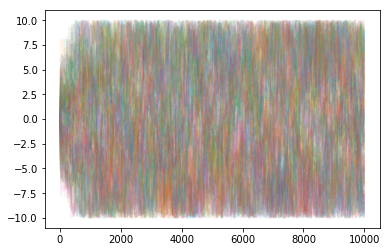

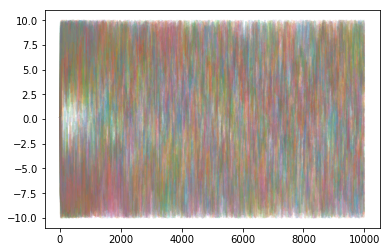

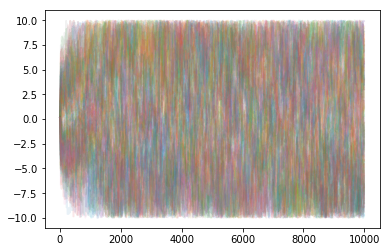

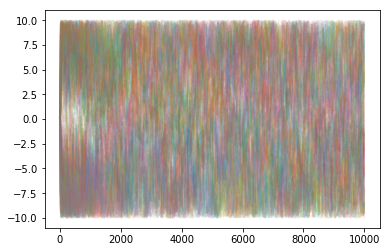

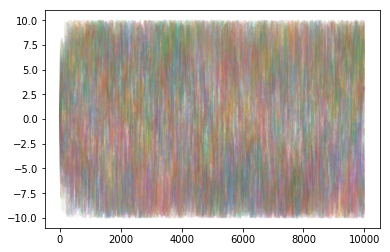

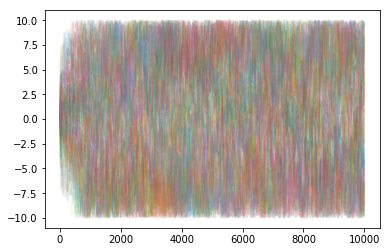

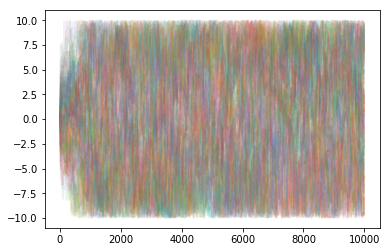

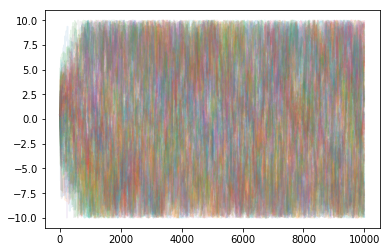

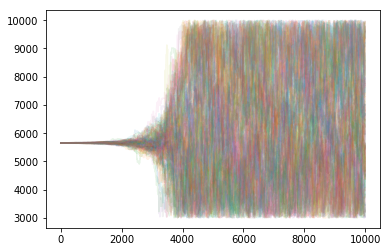

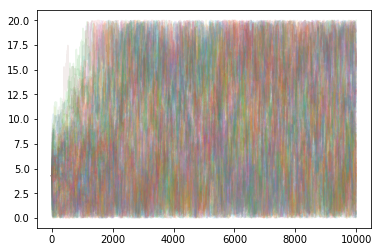

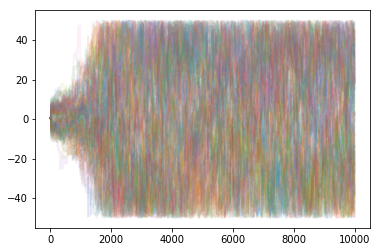

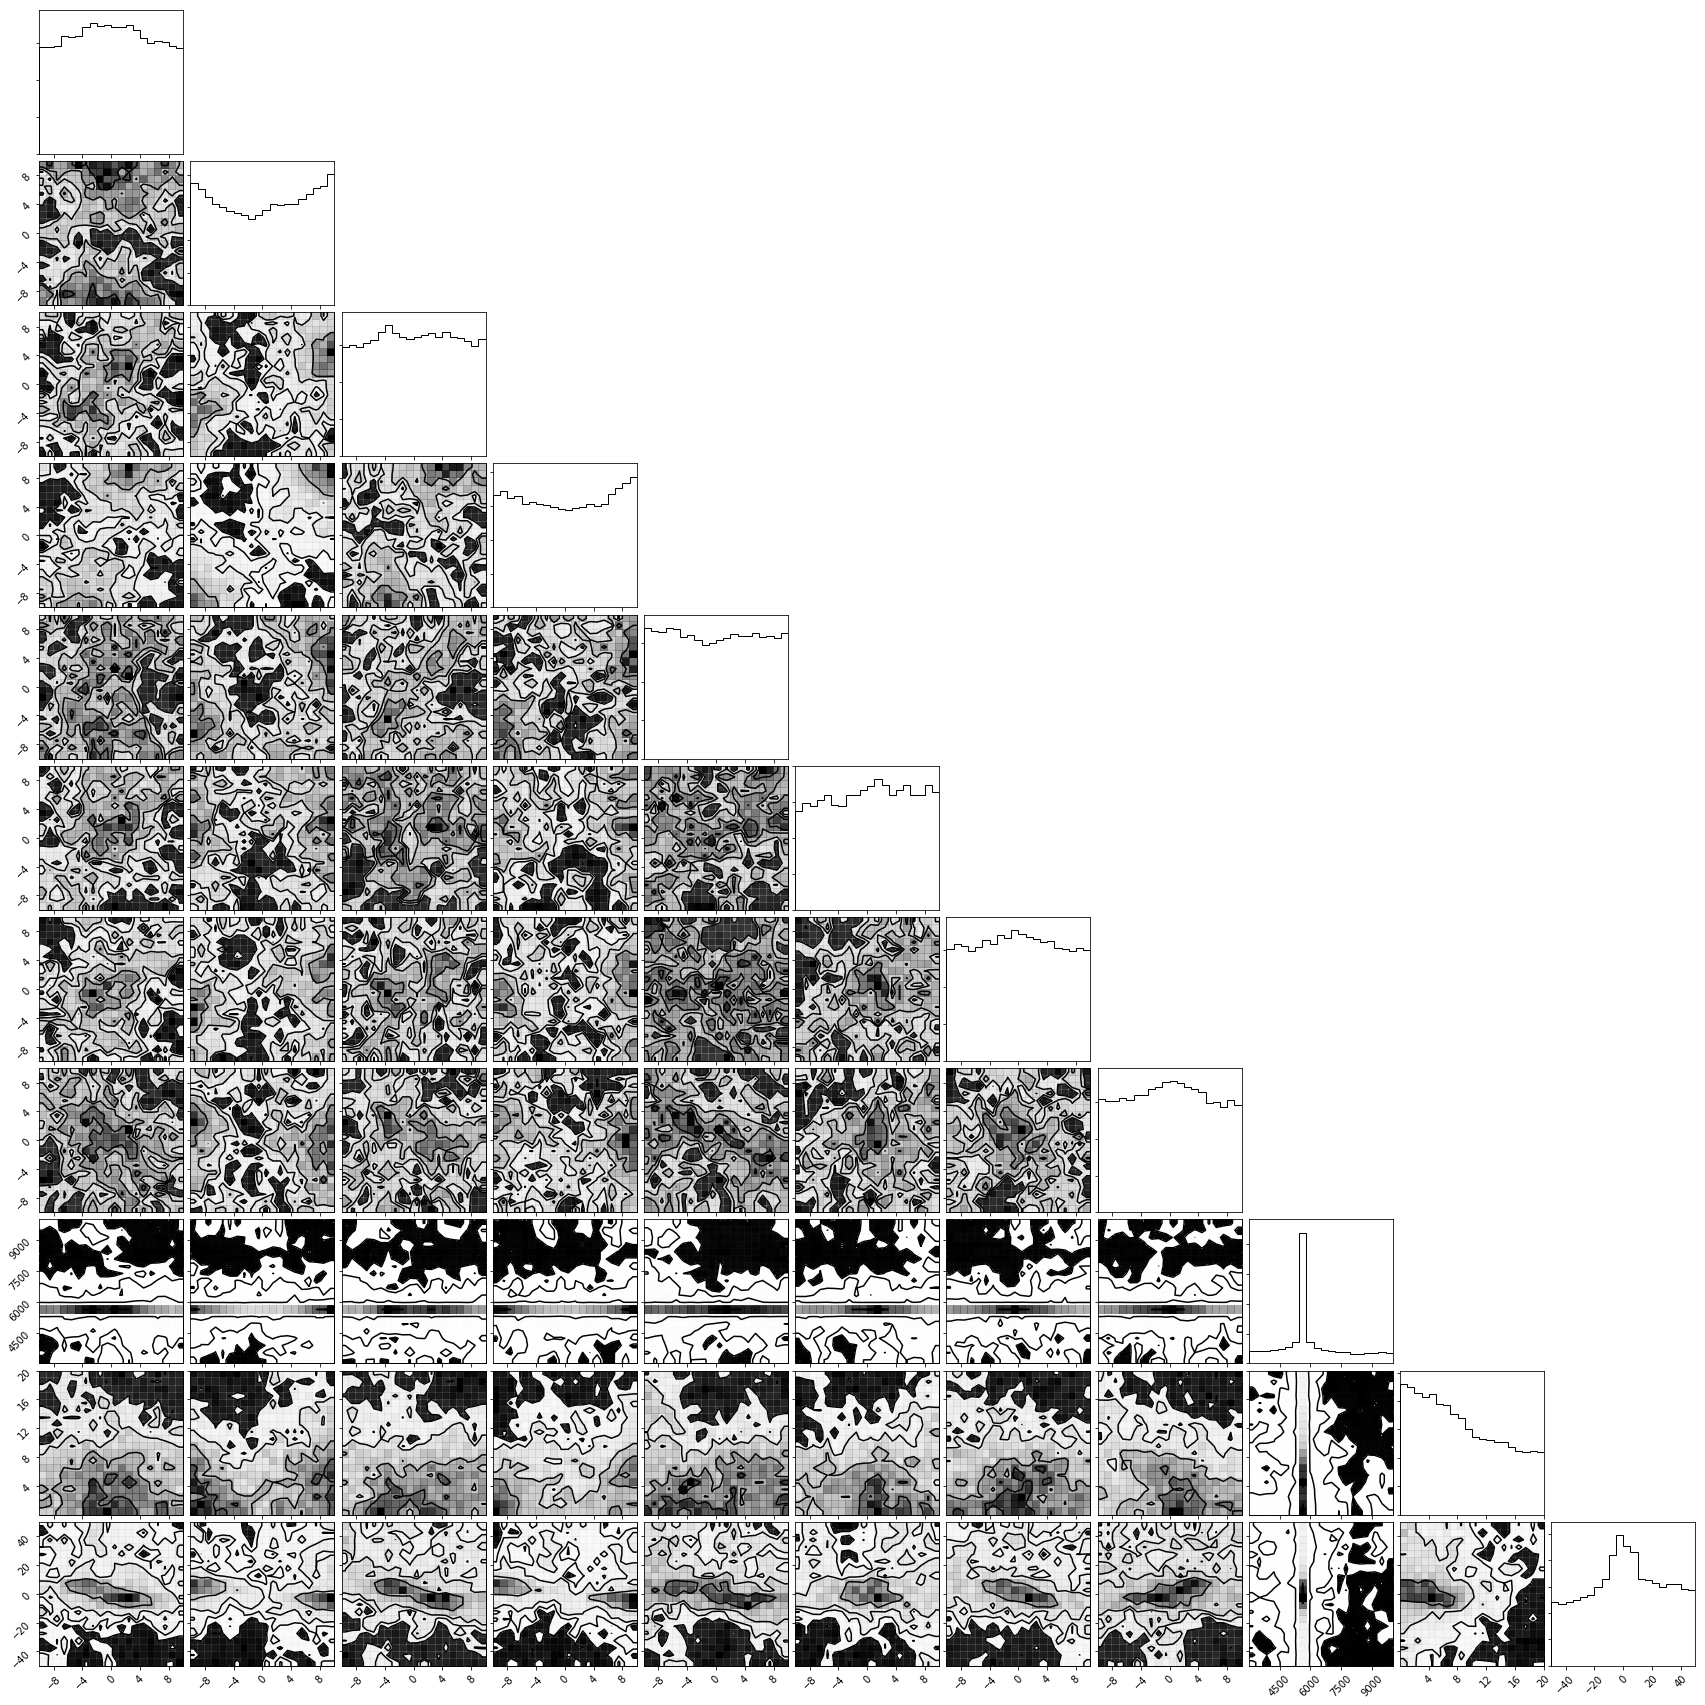

In [17]:
for i in range(ndim):
    plt.plot(sampler.chain[:,:,i].T, '-', alpha=0.1)
    plt.show()
    
samples = sampler.chain[:,20:,:].reshape((-1,ndim))
fig = corner.corner(samples)

In [29]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

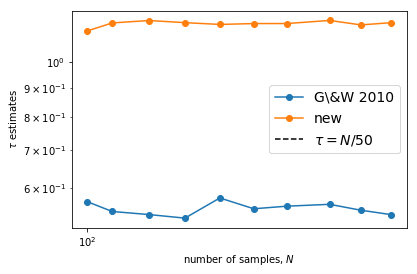

In [30]:
chain = sampler.chain[:, :, 0].T

# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chain[:, :n])
    new[i] = autocorr_new(chain[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

In [32]:
lnlike(labels=popt, data_spec=norm_spec, data_err=spec_err)

-1.2060898252376258e-06